In [2]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
# from google.colab import drive
import matplotlib.lines as mlines

In [3]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.weight": "normal",
    "font.size": 22
})

In [4]:
def defparse(astr):
    dd = {}
    y = astr.strip().split(';')
    for a in y:
        b = a.split('=')
        dd[b[0]] = b[1]
    return dd

# Define the gff_parse function to parse the GFF3 file and extract gene models
def gff_parse(afile, tchr, rstart, rstop):
    fh = open(afile)
    gene_dict = {}
    for x in fh:
        if x[0] == '#': continue
        y = x.strip().split('\t')
        if y[0] != f"{tchr}": continue
        if int(y[3]) > rstop + 100000: continue
        if int(y[4]) < rstart - 100000: continue
        defdict = defparse(y[-1])
        if y[2] == 'mRNA' and defdict.get("longest") == '1':
            mygene = defdict["ID"]
            gene_dict[mygene] = {"start": int(y[3]), "stop": int(y[4]), "utr": [], "cds": [], "strand": y[6]}
        if y[2] == 'CDS':
            mygene = defdict["Parent"]
            if not mygene in gene_dict: continue
            gene_dict[mygene]["cds"].append((int(y[3]), int(y[4]) - int(y[3])))
        if y[2] == "five_prime_UTR" or y[2] == "three_prime_UTR":
            mygene = defdict["Parent"]
            if not mygene in gene_dict: continue
            gene_dict[mygene]["utr"].append((int(y[3]), int(y[4]) - int(y[3])))
    fh.close()
    return gene_dict

/tmp/ipykernel_854143/2085087604.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')
/tmp/ipykernel_854143/2085087604.py:105: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([round(x,3) for x in yticks1])
/tmp/ipykernel_854143/2085087604.py:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels([round(x) for x in yticks2])


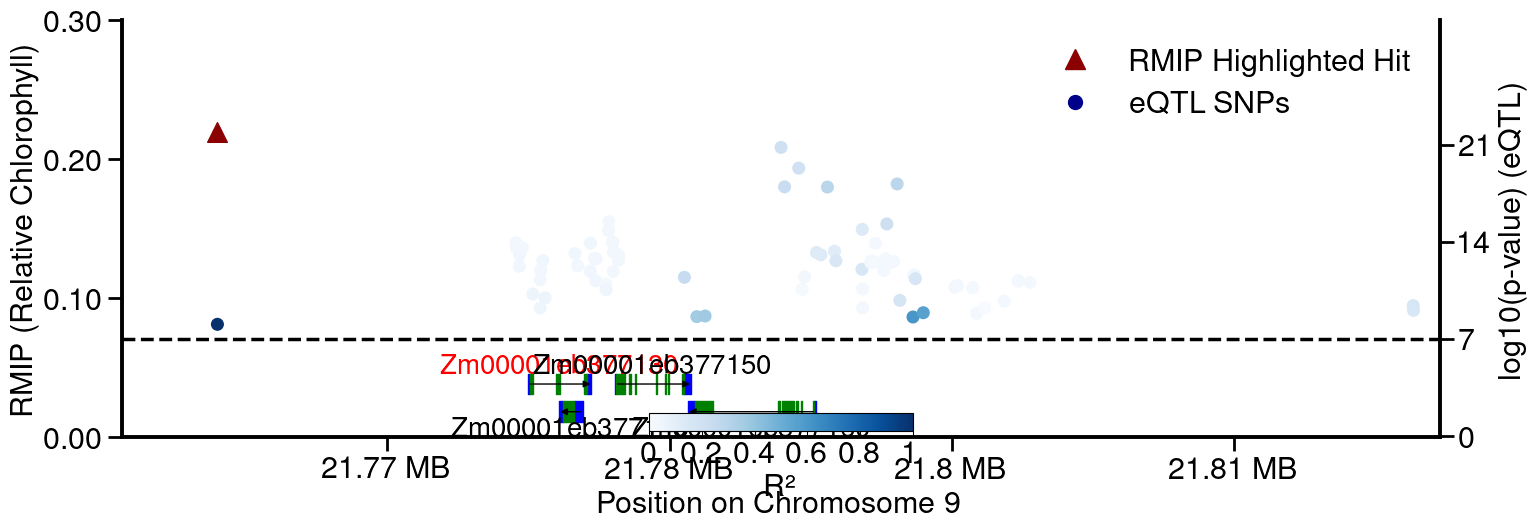

In [5]:
target_chr = 9
target_loc = 21785915
additional_target_loc =21755970# New target locus to highlight
windowsize = 35000  # Adjusted to ensure all genes are visible
stepsize = 15000  # Adjusted for better labeling
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.weight": "normal",
    "font.size": 22
})
# Load gene positions
gene_file = 'Zmays_833_Zm-B73-REFERENCE-NAM-5.0.55.gene.gff3'
gene_dict = gff_parse(gene_file, target_chr, target_loc - windowsize, target_loc + windowsize)
# Load GWAS hits
gwas_file = 'eQTL_significant_SNPs_Zm00001eb33170.csv'
eQTL_hits = pd.read_csv(gwas_file)
eQTL_hits = eQTL_hits.loc[eQTL_hits['CHROM'] == target_chr]
# Load RMIP values
rmip_file = 'multispeqcutoff_final.csv'
rmip_data = pd.read_csv(rmip_file)
rmip_data = rmip_data.loc[rmip_data['CHROM'] == target_chr]
# Load LD values
ld_file = 'ld_chr9.csv'
ld_data = pd.read_csv(ld_file)
# # Merge LD values with eQTL hits, using 'R2' as the LD measure
eQTL_hits = pd.merge(eQTL_hits, ld_data[['POS', 'R2']], on='POS', how='left')
# # Exclude rows with missing R2 values
eQTL_hits = eQTL_hits.dropna(subset=['R2'])
cmap = cm.get_cmap('Blues')
norm = mcolors.Normalize(vmin=0, vmax=1)
# Set up the figure with desired size (1200px width, 710px height)
fig, ax2 = plt.subplots(figsize=(17,6))
# Set up the secondary axis (ax1) for log10(p-value)
ax1 = ax2.twinx()
# Add significance threshold on the secondary axis (log10(p-value))
ax1.plot([target_loc - windowsize, target_loc + windowsize], [7, 7], '--', color='black', linewidth=2.5)
# Plot gene models on the secondary axis (log10(p-value))
for g in gene_dict:
    myname = g.split('_')[0]
    if not myname in ['Zm00001eb377160', 'Zm00001eb377130', 'Zm00001eb377150', 'Zm00001eb377140']: continue
    if gene_dict[g]["strand"] == '+':
        myoffset = 3
        arrow = mpatches.FancyArrowPatch((gene_dict[g]["start"], myoffset+0.75), (gene_dict[g]["stop"] + 100, myoffset+0.75),
                                         arrowstyle='-|>', mutation_scale=10, color="black")
        color = 'red' if myname == 'Zm00001eb377130' else 'black'
        ax1.text((gene_dict[g]["start"] + gene_dict[g]["stop"]) / 2, 4.575, myname, ha="center", color=color, fontsize=20)
    if gene_dict[g]["strand"] == '-':
        myoffset = 1
        arrow = mpatches.FancyArrowPatch((gene_dict[g]["stop"], myoffset+0.75), (gene_dict[g]["start"] - 100, myoffset+0.75),
                                         arrowstyle='-|>', mutation_scale=10, color="black")
        color = 'red' if myname == 'Zm00001eb377130' else 'black'
        ax1.text((gene_dict[g]["start"] + gene_dict[g]["stop"]) / 2, 0.0, myname, ha="center", color=color, fontsize=20)
    ax1.broken_barh(gene_dict[g]["utr"], (myoffset, 1.5), color="blue")
    ax1.broken_barh(gene_dict[g]["cds"], (myoffset, 1.5), color="green")
    ax1.add_patch(arrow)
    if (gene_dict[g]["start"] + gene_dict[g]["stop"]) / 2 < target_loc - windowsize or (gene_dict[g]["start"] + gene_dict[g]["stop"]) / 2 > target_loc + windowsize: continue
    if myname in ['Zm00001eb377160', 'Zm00001eb377130', 'Zm00001eb377150']:
        color = 'red' if myname == 'Zm00001eb377130' else 'black'

# Plot GWAS results with LD values on the secondary axis (log10(p-value))
sc = ax1.scatter(eQTL_hits["POS"], eQTL_hits["logpvalue"], c=eQTL_hits["R2"], cmap=cmap, norm=norm, label="GWAS Peaks", s=70)

# Plot RMIP values on the primary axis (left, ax2)
ax2.set_ylabel('RMIP (Relative Chlorophyll)', color="black")
ax2.set_ylim([0, 0.3])
ax2.scatter(rmip_data["POS"], rmip_data["support"], color="orange", label="RMIP Values")

# # Highlight the additional target locus with a triangle based on RMIP dataset
highlighted_rmip_value = rmip_data.loc[rmip_data['POS'] == additional_target_loc, 'support'].values[0]
ax2.scatter(additional_target_loc, highlighted_rmip_value, color='darkred', marker='^', s=200, label="Highlighted Hit")

# # Add proper x-axis labels
myxticks = list(range(round(target_loc - windowsize, -4), round(target_loc + windowsize, -4) + stepsize, stepsize))
myxticklabels = ["{:,} MB".format(round(t / 1000000,2)) for t in myxticks]

# # Apply visual tweaks
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
for axis in ['bottom', 'left']:
    ax2.spines[axis].set_linewidth(2.8)  # Set axis line thickness to 1.5
ax1.spines['right'].set_linewidth(2.8)  # Set axis line thickness to 1.5

# ax2.spines['left'].set_linewidth(1.5)  # Set axis line thickness to 1.5
ax2.set_xticks(myxticks)
ax2.set_xticklabels(myxticklabels,color="black")
ax2.set_xlabel(f"Position on Chromosome {target_chr}", color="black")
ax2.set_xlim([target_loc - windowsize, target_loc + windowsize])
ax1.set_ylim([-0.1, 30])
ax1.set_ylabel("log10(p-value) (eQTL)", color="black")

ax2.tick_params(width=2, length=10, labelsize=22)  # Set tick label size
ax1.tick_params(width=2, length=10, labelsize=22)  # Set tick label size

# Add colorbar for LD values (R2) at the top center
cbar = plt.colorbar(sc, ax=[ax1, ax2], orientation='horizontal', pad=-0.1, shrink=0.2, aspect=15)
# Set the label with only "2" as a superscript
cbar.set_label('R²', fontsize=22)
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
yticks1= ax2.get_yticks()
yticks2= ax1.get_yticks()
ax2.set_yticklabels([round(x,3) for x in yticks1])
ax1.set_yticklabels([round(x) for x in yticks2])

custom_yticks_primary = [0.0, 0.1, 0.2, 0.3]  # Your custom y-tick values
ax2.set_yticks(custom_yticks_primary)
ax2.set_yticklabels([f"{x:.2f}" for x in custom_yticks_primary])

custom_yticks_secondary = [0, 7, 14, 21]  # Your custom y-tick values
ax1.set_yticks(custom_yticks_secondary)
ax1.set_yticklabels([f"{x:.0f}" for x in custom_yticks_secondary])

# Define custom legend handles for RMIP and eQTL SNPs
rmip_handle = mlines.Line2D([], [], color='darkred', marker='^', linestyle='None', markersize=15, label='RMIP Highlighted Hit')
eqtl_handle = mlines.Line2D([], [], color='darkblue', marker='o', linestyle='None', markersize=10, label='eQTL SNPs')

# Add custom legend to the plot
plt.legend(handles=[rmip_handle, eqtl_handle], loc='upper right', bbox_to_anchor=(1, 1), frameon=False)

# Save the plot to Google Drive
svg_file_path = 'RMIP_and_eQTL_hits_with_specific_genes.svg'
plt.savefig(svg_file_path, format='svg', dpi=300)